In [ ]:
from tensorflow.python.keras.layers.core import Dropout
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import librosa

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pydub import AudioSegment

import os
import cv2
import shutil 
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
curr_dir =  os.path.join("/content/drive/MyDrive/inż-dane/#morgen/H")
%cd "$curr_dir"

/content/drive/MyDrive/inż-dane/#morgen/H


In [ ]:
for file_name in os.listdir(curr_dir):
  if file_name.endswith(".wav") and file_name.startswith("zz"):
    audio1 = AudioSegment.from_file(file_name, "wav")
    normalized_audio1 = audio1.apply_gain(-audio1.max_dBFS)
    name = "new_normalized_" + file_name.split('_')[1]
    normalized_audio1.export(name, format="wav")

In [ ]:
e_f = []
classes = set()

In [ ]:
def extract_features(file_name):
    max_pad_len = 400
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(audio, 44100, n_mfcc=40, hop_length=441, win_length=882, window='hamm', center=True) #n_mels=20)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        #print(mfccs.shape)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(mfccs.shape[1])
        return None 
     
    return mfccs

In [ ]:
curr_dir =  os.path.join("/content/drive/MyDrive/inż-dane/#morgen/H")
%cd "$curr_dir"

/content/drive/MyDrive/inż-dane/#morgen/H


In [ ]:
for filename in os.listdir(curr_dir): #tqdm(metadata.iterrows()):
  if filename.startswith("norm"):
    class_label="H"
    #print(filename)
    classes.add(class_label)
    data=extract_features(filename)
    e_f.append([data,class_label])

In [ ]:
len(e_f)

631

In [ ]:
curr_dir = os.path.join("/content/drive/MyDrive/inż-dane/#morgen/P")
%cd $curr_dir

/content/drive/MyDrive/inż-dane/#morgen/P


In [ ]:
for filename in os.listdir(curr_dir): #tqdm(metadata.iterrows()):
  if filename.startswith("norm") and (len(AudioSegment.from_wav(filename))>0):
    class_label="P"
    classes.add(class_label)
    data=extract_features(filename)
    e_f.append([data,class_label])

In [ ]:
len(e_f)

1975

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
featuresdf = pd.DataFrame(e_f, columns=['feature', 'class_label'])

print(classes)

X1 = np.array(featuresdf.feature.tolist())
y1 = np.array(featuresdf.class_label.tolist())

print(X1.shape)
print(y1.shape)

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y1))

print(yy.shape)

X_train, X_test, y_train, y_test = train_test_split(X1, yy, test_size=0.2, random_state=42)

{'H', 'P'}
(1975, 40, 400)
(1975,)
(1975, 2)


In [ ]:
X_train.shape

(1580, 40, 400)

In [ ]:
num_rows = 40
num_columns = 400
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2



In [ ]:
def construct_model():
	 
	model = Sequential()
	model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
	model.add(MaxPooling2D(pool_size=2))
	model.add(Dropout(0.2))
	
	model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
	model.add(MaxPooling2D(pool_size=2))
	model.add(Dropout(0.2))
	
	model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
	model.add(MaxPooling2D(pool_size=2))
	model.add(Dropout(0.2))
	
	model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
	model.add(MaxPooling2D(pool_size=2))
	model.add(Dropout(0.2))
	model.add(GlobalAveragePooling2D())

	


	model.add(Flatten())
 
	model.add(Dense(128, activation = 'relu'))
 
	model.add(Dropout(0.2))
	model.add(Dense(64, activation = 'relu'))
 
  
	
	model.add(Dense(num_labels, activation='sigmoid'))
	
	# Compile the model
	model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer='adam') 
	
	# Display model architecture summary 
	model.summary()

	

	return model


model = construct_model()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 39, 399, 16)       80        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 199, 16)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 19, 199, 16)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 198, 32)       2080      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 9, 99, 32)        0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 9, 99, 32)        

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)



Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.6671
Epoch 00001: val_loss improved from inf to 0.63524, saving model to saved_models/weights.best.basic_cnn.hdf5
13/13 [==============================] - 17s 1s/step - loss: 0.6179 - accuracy: 0.6671 - val_loss: 0.6352 - val_accuracy: 0.6532
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.6873
Epoch 00002: val_loss improved from 0.63524 to 0.61760, saving model to saved_models/weights.best.basic_cnn.hdf5
13/13 [==============================] - 16s 1s/step - loss: 0.5889 - accuracy: 0.6873 - val_loss: 0.6176 - val_accuracy: 0.6532
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.6861
Epoch 00003: val_loss improved from 0.61760 to 0.60860, saving model to saved_models/weights.best.basic_cnn.hdf5
13/13 [==============================] - 16s 1s/step - loss: 0.5756 - accuracy: 0.6861 - val_loss: 0.6086 - val_accuracy: 

In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8702531456947327
Testing Accuracy:  0.7594936490058899


Best Validation Loss: 0.4747
Best Validation Accuracy: 0.7823


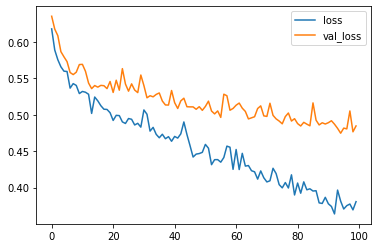

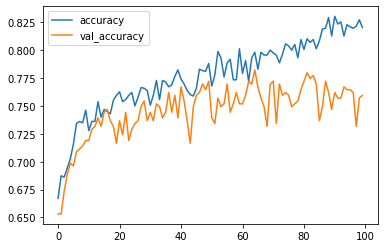

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
Y_Pred = model.predict(X_test)

In [ ]:
y_true= (y_test[:,0])
y_true=np.argmax(y_test)
print(y_true)

1


In [ ]:
y_pred=model.predict(X_test)
prediction_int = np.zeros_like(y_pred)
prediction_int[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(y_test.argmax(axis=1), prediction_int.argmax(axis=1))

#cm = confusion_matrix(y_test1, prediction_int)
print(cm)

[[ 83  57]
 [ 37 214]]


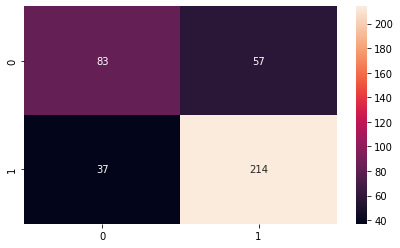

In [ ]:
import seaborn as sn
plt.figure(figsize = (7,4))
sn.heatmap(cm, annot=True, fmt="d")

In [ ]:
import sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
acc = sklearn.metrics.accuracy_score(y_test.argmax(axis=1), prediction_int.argmax(axis=1))
print('Accuracy: %f' % acc)
precision = precision_score(y_test.argmax(axis=1), prediction_int.argmax(axis=1))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test.argmax(axis=1), prediction_int.argmax(axis=1))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.argmax(axis=1), prediction_int.argmax(axis=1))
print('F1 score: %f' % f1)

Accuracy: 0.759591
Precision: 0.789668
Recall: 0.852590
F1 score: 0.819923
